$\large \textbf{ Nomes:}$

Carlos Beiramar a84628

Ricardo Cruz a86789

# Algoritmo de Groover

Em 1996, Lov Grover apresentou um algoritmo de procura desordenada.

Considerando uma lista de 0 até N, existe um objeto <b>w</b> que se quer localizar nessa mesma lista. 

|$0$|$0$|$0$||$1$||$0$|$0$|
|-|-|-|-|-|-|-|-|
|$0$|$1$|$2$|...|$w$|...|$N-1$|$N=2^n$|

Num computador clássico:
<ul>
    <li> o pior caso é N;</li> 
    <li> caso médio é $\frac{N}{2}$.</li>
</ul>

Num computador quântico:
<ul>
    <li> o pior caso é $\sqrt{N}.$
</ul>

In [120]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.providers.aer.noise import NoiseModel
import operator

In [121]:
w = 2 % 8
print(w)

2


In [122]:
wb = bin(w)[2:] 

print(wb)

10


In [123]:
x = 3
print('number of qubits: ', x)

number of qubits:  3


In [124]:
qr_x = QuantumRegister(x, 'x')

In [125]:
backend = Aer.get_backend("qasm_simulator")
backend_vector = Aer.get_backend('statevector_simulator')

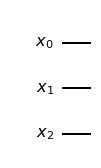

In [126]:
qc_Grover= QuantumCircuit(qr_x)
qc_Grover.draw(output = 'mpl')

state-vector antes de inicializar: 
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


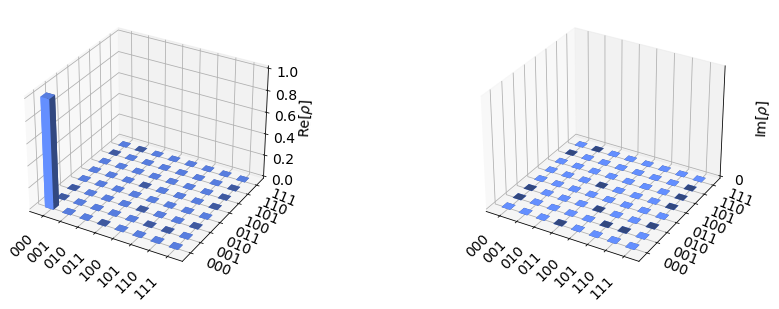

In [127]:
result = execute(qc_Grover, backend_vector).result()
qstate= result.get_statevector(qc_Grover)
print("state-vector antes de inicializar: \n", qstate)
plot_state_city(qstate)

A função <b>initialize</b> inicia todos os <i>qubits</i>, ou seja, vai colocá-los em superposição usando portas Hadamard. Irá retornar um novo circuito quântico.




$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} (\lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle)$

In [128]:
def initialize(qc_Grover,qubits):
    for q in qubits:
        qc_Grover.h(q)
    return qc_Grover

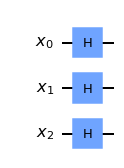

In [129]:
# init
qc_Grover = initialize(qc_Grover, qr_x)
qc_Grover.draw(output = 'mpl')

state-vector depois de inicializar: 
 [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


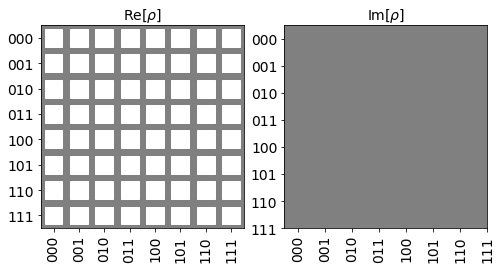

In [130]:
result = execute(qc_Grover, backend_vector).result()
qstate= result.get_statevector(qc_Grover)
print("state-vector depois de inicializar: \n", qstate)
plot_state_hinton(qstate)

Como o nosso $\lvert$ w $\rangle$ = $\lvert$ 010 $\rangle$, o que significa que queremos que o computador quântico descubra este estado e ignore os outros. Para isso, começámos por marcar os qubits que queremos que fiquem a 0, neste caso são os qubits 0 e 2. Após isto, queremos decompor o <b>control Z</b>(porta ccz), usando as portas <b>hadamard</b> e <b>ccx</b>

$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} (\lvert000\rangle + \lvert001\rangle - \lvert010\rangle + \lvert011\rangle + \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle)$

In [131]:
def phase_oracle2(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.x(0)
    qc.x(2)
    qc.h(2)
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(0)
    qc.x(2)
    
    oracle = qc.to_gate()
    oracle.name = "U$_\omega$"
    
    return oracle

<ol type="1">
<li>Aplicação da porta $\textbf{Hadamard}$</li>
$$\lvert \psi_{3a} \rangle = \frac{1}{2} (\lvert000\rangle + \lvert011\rangle + \lvert100\rangle - \lvert111\rangle)$$ <br />  
 
<li>Aplicação da porta $\textbf{X}$ aos qubits</li>
$$\lvert \psi_{3b} \rangle = \frac{1}{2} (-\lvert000\rangle + \lvert011\rangle + \lvert100\rangle + \lvert111\rangle)$$<br />

<li> Aplicação da porta $\textbf{control Z}$ </li>
$$\lvert \psi_{3c} \rangle = \frac{1}{2} (-\lvert000\rangle + \lvert011\rangle + \lvert100\rangle - \lvert111\rangle)$$<br />

<li> Aplicação da porta $\textbf{X}$ aos qubits</li>
$$\lvert \psi_{3d} \rangle = \frac{1}{2} (-\lvert000\rangle + \lvert011\rangle + \lvert100\rangle - \lvert111\rangle)$$<br />
    
<li> Aplicação da porta $\textbf{Hadamard}$ aos qubits</li>
$$\lvert \psi_{3d} \rangle = \frac{1}{2} (-\lvert010\rangle)$$<br />   
</ol>

In [132]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    for qubit in range(nqubits):
        qc.x(qubit)
        
    qc.h(nqubits-1)
    qc.ccx(0,1,2)
    qc.h(nqubits-1)
    
    for qubit in range(nqubits):
        qc.x(qubit)
        
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

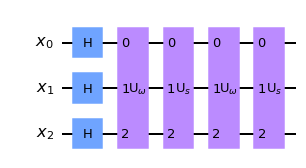

In [133]:
# oracle and difuser 

for t in range(2):
    # phase oracle 2 
    qc_Grover.append(phase_oracle2(x), qr_x)
    
    # diffuser
    qc_Grover.append(diffuser(x), qr_x)
    
qc_Grover.draw(output = 'mpl')

state-vector depois do óraculo: 
 [-0.08838835+2.16489014e-17j -0.08838835+3.24733521e-17j
  0.97227182+1.08244507e-17j -0.08838835+1.51542310e-16j
 -0.08838835-1.08244507e-17j -0.08838835+2.16489014e-17j
 -0.08838835-2.16489014e-17j -0.08838835+5.41222535e-17j]


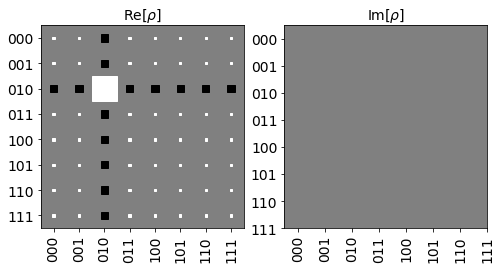

In [134]:
result = execute(qc_Grover, backend_vector).result()
qstate= result.get_statevector(qc_Grover)
print("state-vector depois do óraculo: \n", qstate)
plot_state_hinton(qstate)

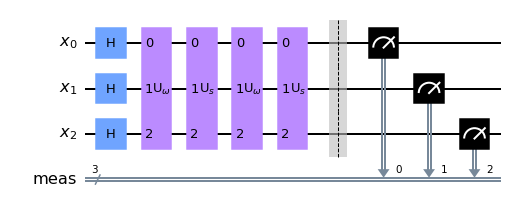

In [135]:
qc_Grover.measure_all()

qc_Grover.draw(output='mpl')

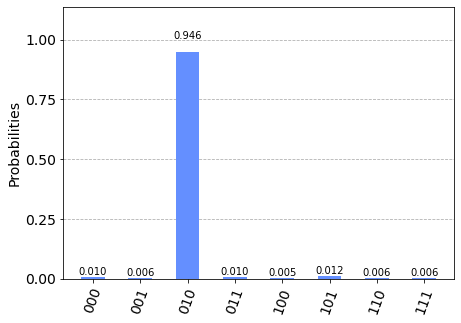

In [136]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

# IBM Q Backend

In [137]:
#save_account needs to be run only once
IBMQ.save_account('76e1c12758b397a2b16afb3b44325fbd498983773831531426ea6acf41712cf0e431919a898d4e9856b96935cc3c22c249aa86705160e3568ab467a51784b266')

configrc.store_credentials:WARNING:2021-06-05 18:14:56,708: Credentials already present. Set overwrite=True to overwrite.


In [138]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [139]:
import qiskit.tools.jupyter

%qiskit_backend_overview

In [140]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 2              Pending Jobs: 6              Pending Jobs: 2
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      151.0          Avg. T1:      75.2           Avg. T1:      79.3
Avg. T2:      67.0           Avg. T2:      73.2           Avg. T2:      91.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 5              Pending Jobs: 10             Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operatio

## Simulador de Ruído 

A função <i>backend_device_chooser</i> recebe como parâmetro um device e vai definir o backend device.

In [141]:
#aqui tem de escolher com base na optimização

def backend_device_chooser(device):
    backend_device = provider.get_backend(device)
    print("Running on: ", backend_device)
    return backend_device

A função <i>coupling</i> receber o backend device como parâmetro e retorna o coupling_map.

In [142]:
def coupling(backend_device):
    coupling_map = backend_device.configuration().coupling_map
    return coupling_map

A função <i>noise_model_construction</i> recebe como parâmetro o backend device e define o noise_model de acordo com esse backend device.

In [143]:
def noise_model_construction(backend_device):
    # Construct the noise model from backend properties
    noise_model = NoiseModel.from_backend(backend_device)
    #print(noise_model)
    return noise_model

A função <i>basis_gates_model</i> recebe como parâmetro o noise_model e retorna o basis gate desse noise model.

In [144]:
def basis_gates_model(noise_model):
    # Get the basis gates for the noise model
    basis_gates = noise_model.basis_gates
    #print(basis_gates)
    return basis_gates

A função <i>noise_calculation</i> recebe como parâmetro tudo que foi retornado nas funções anteriores. Executa uma simulação do ruído e retorna o contador de ruído do nosso circuito quântico.

In [145]:
def noise_calculation(backend_device, noise_model, basis_gates, coupling_map):
    # Execute noisy simulation and get counts
    result_noise = execute(qc_Grover, backend, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates).result()

    counts_noise = result_noise.get_counts(qc_Grover)
    return counts_noise

A função <i>maximum</i> recebe como parâmetro um dicionário onde a chave é nome do device e o value é o <i>counts_noise</i>.
Vai determinar o device que tem maior valor e vai retornar o nome do device com maior valor, ou seja, o que tem menos ruído.

In [146]:
def maximum(devices_adj):
    device_name = ""
    maximum = 0
    for device in devices_adj:
        if devices_adj[device]["010"] > maximum:
            maximum = devices_adj[device]["010"]
            device_name = device
    return device_name

A função <i>choose_device_main</i> percorre a lista com todos os devices possíveis e executa as funções implementadas anteriormente. Vai retornar o <i>counts_noise</i> do dispositivo com menos ruído e o backend device.

In [170]:
def choose_device_main():
    devices = ["ibmq_manila", "ibmq_quito", "ibmq_belem", "ibmq_lima", "ibmq_santiago","ibmq_athens",
           "ibmq_16_melbourne","ibmqx2"]
    devices_adj = {}

    for device in devices:
        backend_device = backend_device_chooser(device)
        coupling_map = coupling(backend_device)
        noise_model = noise_model_construction(backend_device)
        basis_gates = basis_gates_model(noise_model)
        counts_noise = noise_calculation(backend_device, noise_model, basis_gates, coupling_map)
        #print(noise_results)
        if device not in devices_adj:
            devices_adj[device] = counts_noise
    #print("\nNoise on 010: ", devices_adj)
    device_name = maximum(devices_adj)
    
    print("Device Choosen", device_name)
    
    return devices_adj[device_name],backend_device

In [171]:
counts_noise,backend_device = choose_device_main()

Running on:  ibmq_manila
Running on:  ibmq_quito
Running on:  ibmq_belem
Running on:  ibmq_lima
Running on:  ibmq_santiago
Running on:  ibmq_athens
Running on:  ibmq_16_melbourne
Running on:  ibmqx2
Device Choosen ibmq_santiago


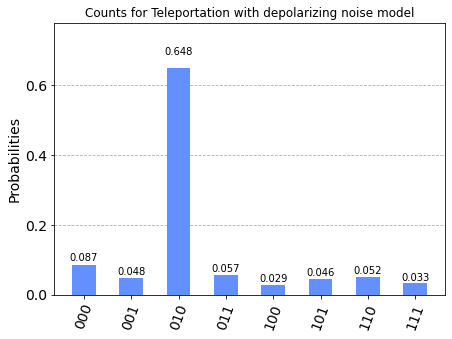

In [153]:
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

## Execução numa IBM Q Backend

In [1]:
#backend_monitor(backend_device)

In [155]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [156]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bbb1bc00aded148e6a6fec


In [158]:
#ibmq_essex 1 times the oracle:
job_get=backend_device.retrieve_job("60bbb1bc00aded148e6a6fec")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

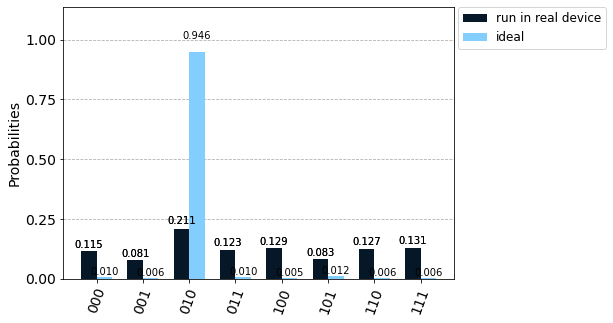

In [159]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

# IGNIS

In [161]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

## Matriz de Calibração

Gerar a lista das medidas dos circuitos de calibração.

O circuito cria a lista dos estados base.

Como só usámos 3 qubits, precisámos de $2^3 = 8$ circuitos de calibração.

In [162]:
# Generate the calibration circuits
qr = QuantumRegister(x)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [163]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

## Cálculo da matriz de calibração

Caso não haja ruído no dispositivo, a matriz de calibração deverá ser uma matriz identidade $8*8$. Visto que o cálculo da matriz é feito a partir de um dispositivo quântico real, irá haver algum ruído.

In [164]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bbb25636b2bea37724fe3d


In [165]:
job_get=backend_device.retrieve_job("60bbb25636b2bea37724fe3d")

cal_results = job_get.result()

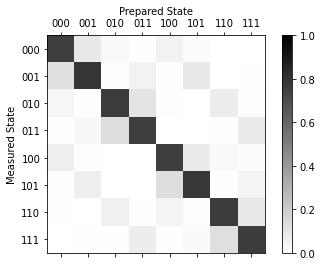

In [166]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

## Análise de resultados

A fidelidade média de atribuição é a diagonal principal da matriz anterior.

In [167]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.765137


## Aplicação da calibração

Aplicámos um filtro para obter <i>mitigated_counts</i>.

In [168]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

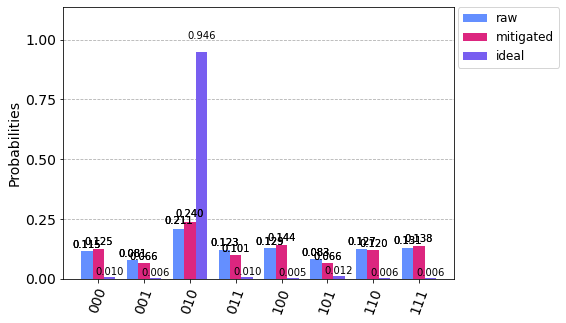

In [169]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])

# Referências

Aulas práticas.

https://qiskit.org/textbook/ch-algorithms/grover.html
